In [1]:
import numpy as np
import torch
import torch.nn as nn

from nets import GraphNN_KNN_v1, EdgeClassifier_v1
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, average_precision_score
from torch_geometric.data import DataLoader
from preprocessing import preprocess_dataset
from tqdm import tqdm

def predict_one_shower(shower, graph_embedder, edge_classifier):
    # TODO: batch training
    embeddings = graph_embedder(shower)
    edge_labels_true = ((shower.y[shower.edge_index[0]] == shower.y[shower.edge_index[1]])).view(-1)
    edge_labels_predicted = edge_classifier(shower=shower, embeddings=embeddings, edge_index=shower.edge_index).view(-1)
    return edge_labels_true, torch.clamp(edge_labels_predicted, 1e-6, 1 - 1e-6)

In [2]:
import hdbscan
from hdbscan import plots as hdbscan_plot
import networkx as nx
from clustering import preprocess_torch_shower_to_nx
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(context='paper', style="whitegrid", font_scale=2)


min_cl = 40
cl_size = min_cl

In [3]:
datafile='../rand_preprocessed.pt'; epochs=1000; learning_rate=1e-3; dim_out=144; device='cpu';
device = torch.device("cpu")
showers = torch.load(datafile)

In [4]:
############
print(len(showers))
###########
input_dim = showers[0].x.shape[1]
edge_dim = showers[0].edge_features.shape[1]
output_dim = 32
hidden_dim = 32
num_layers_emulsion = 3
num_layers_edge_conv = 5

107


In [5]:
graph_embedder_weights = "../graph_embedder_rand_preprocessed_45959c8a2e3a4ec69eb31abfb5ad5f54.pt"
edge_classifier_weights = "../edge_classifier_rand_preprocessed_45959c8a2e3a4ec69eb31abfb5ad5f54.pt"

In [6]:
graph_embedder = GraphNN_KNN_v1(
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    edge_dim=edge_dim,
    num_layers_emulsion=num_layers_emulsion,
    num_layers_edge_conv=num_layers_edge_conv,
    input_dim=input_dim,
).to(device)
edge_classifier = EdgeClassifier_v1(
    input_dim=2 * output_dim + edge_dim,
).to(device)
graph_embedder.load_state_dict(torch.load(graph_embedder_weights, map_location=device))
edge_classifier.load_state_dict(torch.load(edge_classifier_weights, map_location=device))
graph_embedder.eval()
edge_classifier.eval()

EdgeClassifier_v1(
  (_layers): ModuleList(
    (0): Linear(in_features=71, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=32, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [10]:
def predict_one_shower(shower, graph_embedder, edge_classifier):
    # TODO: batch training
    embeddings = graph_embedder(shower)
    edge_labels_true = (~(shower.y[shower.edge_index[0]] == shower.y[shower.edge_index[1]])).view(-1)
    edge_labels_predicted = edge_classifier(shower=shower, embeddings=embeddings, edge_index=shower.edge_index).view(-1)
    return edge_labels_true, torch.clamp(edge_labels_predicted, 1e-6, 1 - 1e-6)

In [13]:
from torch_geometric.data import DataLoader
showers = DataLoader(showers, batch_size=1, shuffle=False)

In [16]:
shower = next(iter(showers))

In [28]:
roc_aucs = []
num_showers = []

with torch.no_grad():
    for shower in tqdm(showers):
        true_labels, weights = predict_one_shower(shower, graph_embedder=graph_embedder, edge_classifier=edge_classifier)
        roc_aucs.append(1 - roc_auc_score(true_labels.detach().numpy(), weights.detach().numpy()))
        num_showers.append(shower.y.max())

  0%|          | 0/107 [00:00<?, ?it/s]/root/miniconda/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
  1%|          | 1/107 [00:26<47:02, 26.62s/it]/root/miniconda/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
  2%|▏         | 2/107 [00:41<34:46, 19.88s/it]/root/miniconda/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
  3%|▎         | 3/107 [00:55<29:43, 17.15s/it]/root/miniconda/lib/python3.8/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the i

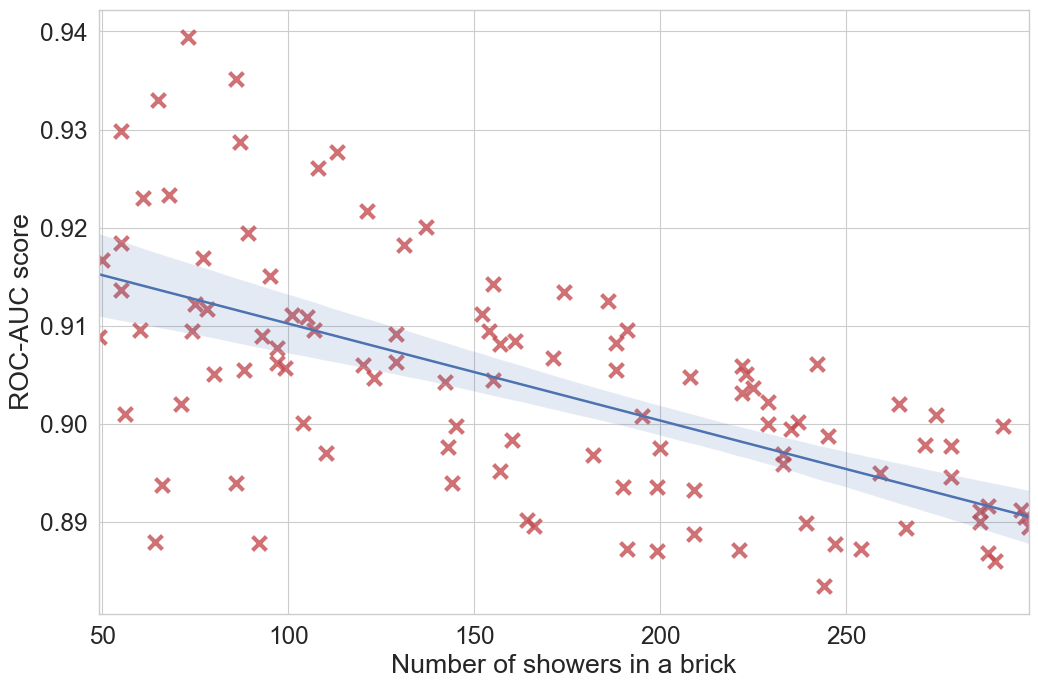

In [46]:
plt.figure(figsize=(12, 8), dpi=100)

sns.regplot(x=num_showers, 
            y=roc_aucs, 
            marker="x",
            scatter_kws={"color": 'r', "s":100, "marker": "x", "linewidths": 3});

plt.ylabel("ROC-AUC score")
plt.xlabel("Number of showers in a brick")
plt.savefig("roc_auc_per_brick.pdf", bbox_inches='tight')
plt.show()